Музыкальная платформа стремится автоматизировать процесс оценки качества результатов поисковой выдачи треков. 
Ранее этот процесс выполнялся вручную: эксперты размечали, насколько результаты поиска соответствуют запросам пользователей. Теперь компания хочет использовать LLM для автоматической оценки релевантности и качества поисковой выдачи на основе запроса пользователя. 

**Цель** — разработать промпт для модели, оценивающий выдачу (результат поисковой выдачи) так же эффективно, как и эксперты.

**Задачи:**
- Изучить оценки, их описания (*[см. ниже](#инструкция)*) и валидационный сет `valid_set.tsv`.
- Разработать промпт.
- Посчитать метрики результатов финального промпта.

<a id="инструкция"></a>

# **<span>Оценки и их описания, которые использовались экспертами при разметке:</span>** 

### **Искали именно это `vital`:**
- Благодаря этому ответу пользователь, скорее всего, нашел, что искал. Оценку нужно выбирать, если из запроса понятно, что нужна именно эта песня и именно этого исполнителя.
- В запросе указан только один исполнитель, а предлагаемый трек содержит несколько исполнителей (в числе которых есть запрошенный), и нет данного трека в исполнении только одного запрошенного исполнителя
- Найдена версия трека, относящаяся к категории Идентичные.
- Найденная версия трека совпадает с той, которую искал пользователь.
- Запрос по тексту песни с обязательным указанием исполнителя, у показанного исполнителя только одна песня с таким текстом.
- Искали конкретный саундтрек (песню, музыку) из конкретного фильма/мультфильма/сериала/игры, нашли нужную песню. Название фильма имеется в названии трека. Название фильма может быть написано на языке оригинала.

### **Полезная поисковая выдача `rel_plus`:**
- Ищут именно песню и именно с таким названием, но популярных версий этой песни может быть больше, чем одна.
- Запрос не по названию песни, а по тексту или близко к смыслу тексту, который содержится в песне.
- Запросили нескольких исполнителей без указания на конкретную песню, нашли трек в их совместном исполнении.
- Запрос про исполнителя, нашли песню этого исполнителя (лучше было найти самого исполнителя).
- Запрос про жанр, найдена песня в этом жанре.
- Запрос про альбом, нашли одну из песен этого альбома (лучше было найти сам альбом).
- В запросе указан только один исполнитель, а предлагаемый трек содержит несколько исполнителей (в числе которых есть запрошенный), и есть данный трек в исполнении только запрошенного исполнителя
- Из запроса до конца непонятно, что именно хотел пользователь, но такую песню в принципе можно предложить
- Запрошена конкретная версия трека, найдена другая версия этого трека из категорий Идентичные или Допустимые.
- Искали конкретную сказку, нашли какую-то часть этой сказки.
- Пользователь, вероятно ошибся с автором песни, но, очевидно, понятно, что пользователь хотел именно этот трек.
- Спросили саундтрек (песню, музыку) в общем из какого-то конкретного фильма (либо сериала, мультфильма и др.), нашли один из саундтреков упомянутого фильма, название фильма имеется в названии трека. Название фильма может быть написано на языке оригинала.

### **Поисковая выдача могла быть лучше `rel_minus`:**
- Существует более популярная широко известная песня (знакомая каждому) с похожим названием
- Просили нескольких исполнителей, нашли песню хотя бы одного из них.
- Найдена версия трека, относящегося к категории Недопустимые, но пользователь НЕ запрашивал такую версию трека.
- Искали конкретный саундтрек (песню, музыку) из конкретного фильма/мультфильма/сериала/игры, нашли другую песню из нужного фильма/мультфильма/сериала/игры. Название фильма имеется в названии трека. Название фильма может быть написано на языке оригинала.

### **Поисковая выдача совсем не та `notreal`:**
- Ответ бесполезен, не подходит на запрос.
- Найден совершенно другой трек/исполнитель, не упомянутый в запросе.
- Предложен трек другого жанра/тематики, не соответствующий запросу.

# **<span>Валидационный сет и его описание</span>** 

*Прочитайте валидационный сет (`valid_set.tsv`)*

- **query** - это запрос пользователя в сервис музыки;
- **track_name** - название трека из поисковой выдачи; 
- **author** - исполнитель из поисковой выдачи; 
- **golden_answer** - верный ответ (при разработке промпта и подсчете метрик, необходимо ориентироваться на эту колонку)

In [313]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_gigachat import GigaChat
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import json
import seaborn as sns
import pickle
import hashlib
import re
import time
import re
import requests


In [314]:
# валидационный сет для разработки и дальнейшей корректировки промпта

test = pd.read_csv('valid_set.tsv', sep='\t')
dev, hold_out = train_test_split(
    test,
    test_size=0.3,  
    stratify=test['golden_answer'],
    random_state=42
)

# Проверка распределений
print("Dev set distribution:\n", dev['golden_answer'].value_counts(normalize=True))
print("Hold-out set distribution:\n", hold_out['golden_answer'].value_counts(normalize=True))


Dev set distribution:
 golden_answer
rel_plus     0.369863
vital        0.273973
notrel       0.205479
rel_minus    0.150685
Name: proportion, dtype: float64
Hold-out set distribution:
 golden_answer
rel_plus     0.37500
vital        0.25000
notrel       0.21875
rel_minus    0.15625
Name: proportion, dtype: float64


In [315]:
dev.sample()

,query,track_name,author,golden_answer
36,а моя любовь живет,Где живёт любовь моя?,Алина Атласова,notrel


In [316]:
print(len(dev))
print(dev.isnull().sum())
print(dev.duplicated().sum())

73
query            0
track_name       0
author           0
golden_answer    0
dtype: int64
0


In [317]:
dev['query_len'] = dev['query'].str.split().apply(len)
dev['author_len'] = dev['author'].str.split(',').apply(len)

In [318]:
dev.groupby(['golden_answer'])['author_len'].mean()

golden_answer
notrel       1.133333
rel_minus    2.090909
rel_plus     1.222222
vital        1.300000
Name: author_len, dtype: float64

In [319]:
dev.groupby(['golden_answer'])['query_len'].mean()

golden_answer
notrel       4.200000
rel_minus    3.181818
rel_plus     2.851852
vital        4.800000
Name: query_len, dtype: float64

In [320]:
dev[dev['author_len'] > 1]['golden_answer'].value_counts()

golden_answer
rel_minus    7
vital        5
rel_plus     4
notrel       1
Name: count, dtype: int64

In [321]:
print('Распределение релевантности когда получаем автора, указанного в запросе:')
dev['author_in_query'] = dev.apply(lambda x: x['author'].lower() in x['query'].lower(), axis=1)
print(dev[dev['author_in_query'] == 1]['golden_answer'].value_counts())


print('\nРаспределение релевантности когда получаем песню название которой, указанно в запросе:')
dev['name_in_query'] = dev.apply(lambda x: x['track_name'].lower() in x['query'].lower(), axis=1)
print(dev[dev['name_in_query'] == 1]['golden_answer'].value_counts())


print('\nРаспределение релевантности когда оба условия совпадают:')
print(dev[dev['name_in_query'] & dev['author_in_query']]['golden_answer'].value_counts())

Распределение релевантности когда получаем автора, указанного в запросе:
golden_answer
rel_plus    8
vital       7
Name: count, dtype: int64

Распределение релевантности когда получаем песню название которой, указанно в запросе:
golden_answer
vital        12
rel_plus     10
notrel        5
rel_minus     1
Name: count, dtype: int64

Распределение релевантности когда оба условия совпадают:
golden_answer
vital       5
rel_plus    1
Name: count, dtype: int64


In [322]:
def categorize_query(query):
    query_lower = query.lower()
    if re.search(r'\b(саундтрек|музыка из|песня из|из фильма|из сериала|из игры|ost)\b', query_lower):
        return 'soundtrack'
    elif re.search(r'\b(альбом|диск|хиты|песня для|музыка для|альбом для|музыка чтобы|песня чтобы)\b', query_lower):
        return 'album'
    elif re.search(r'\b(жанр|стиль)\b', query_lower):
        return 'genre'
    elif re.search(r'\b(песня|трек|включи|поставь)\b', query_lower):
        return 'song'
    else:
        return 'other'

dev['query_category'] = dev['query'].apply(categorize_query)
print("Распределение категорий запросов по классам:")
print(pd.crosstab(dev['golden_answer'], dev['query_category']))

Распределение категорий запросов по классам:
query_category  album  other  song  soundtrack
golden_answer                                 
notrel              0      5    10           0
rel_minus           1      4     6           0
rel_plus            1     10    15           1
vital               0      7    13           0


In [323]:
dev[dev['query_category'] == 'other'].head()

,query,track_name,author,golden_answer,query_len,author_len,author_in_query,name_in_query,query_category
38,мой друг,Мой друг,"Игорь Крутой, Игорь Николаев",rel_plus,2,2,False,True,other
95,титаник музыка,На Титанике,"Лолита,INSTASAMKA",rel_minus,2,2,False,False,other
82,шансон шансон,Chanson (1887),Erik Satie,rel_minus,2,1,False,False,other
72,antonia amor,Amor,Antonia,vital,2,1,True,True,other
22,one di,Di One,"Krss,Seiji",rel_minus,2,2,False,False,other


In [324]:
load_dotenv()
api_key = os.getenv("GIGACHAT_API_KEY")

In [325]:
# Авторизация в GigaChat
llm = GigaChat(
    credentials=api_key, 
    scope="GIGACHAT_API_PERS",
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    streaming=False,
    temperature=0.1 # Уменьшим для точных(детерменированных) ответов
)

In [326]:
features = ['query', 'track_name', 'author']
X_dev = dev[features]
y_dev = dev['golden_answer']
X_test = test[features]
y_test = test['golden_answer']

*Был применен RAG-подход, используя Deezer API для создания контекста. Это позволило модели проверять наличие более релевантных версий треков или исполнителей, что критично для разграничения классов `rel_plus` и `rel_minus`* 


In [328]:
def search_deezer(query, limit=3):
    """Ищет треки по названию/исполнителю в Deezer API."""
    url = "https://api.deezer.com/search"
    params = {"q": query}
    try:
        time.sleep(0.5)
        r = requests.get(url, params=params)
        r.raise_for_status()
        data = r.json()
        results = []
        for track in data.get("data", [])[:limit]:
            results.append({
                "title": track["title"],
                "artist": track["artist"]["name"],
                "album": track["album"]["title"]
            })
        return results
    except requests.RequestException as e:
        print(f"Ошибка Deezer API для {query}: {e}")
        return ['r']

def build_rag_context(track_name, author):
    """Строит текстовый контекст для LLM на основе поиска в Deezer по track_name и author."""
    # Поиск кандидатов по автору и треку
    candidates_author = search_deezer(author, limit=3) 
    candidates_track = search_deezer(track_name, limit=3)
    
    context = ""
    if candidates_author:
        context += "Кандидаты для автора {}:\n{}\n".format(
            author, "\n".join([f"{c['artist']} — {c['title']} (альбом: {c['album']})" for c in candidates_author])
        )
    if candidates_track:
        context += "Кандидаты для трека {}:\n{}\n".format(
            track_name, "\n".join([f"{c['artist']} — {c['title']} (альбом: {c['album']})" for c in candidates_track])
        )
    if not context:
        context = "Кандидаты не найдены."
    return context

# **<span>Разработка промпта и генерации</span>** 

In [330]:
system_prompt = """Ты — эксперт по оценке релевантности выдачи музыкальных треков по запросу пользователя. Твоя задача — классифицировать результаты поиска по четырём классам: vital, rel_plus, rel_minus, notrel.
### Что дается:
- Запрос пользователя: строка в которой описано что пользователь хочет послушать. В запросе может быть указан автор трека, название трека, альбом, жанр музыки, саундтрек из фильма/сказки.
- Результат сервиса: {"author": "<имя или список>", "track_name": "<название трека>"}.
- Контекст, который ты использеушь для проверки.

Как использовать контекст:
В контексте тебе даны: 
- Кандидаты треков 
- Кандидаты авторов
1. Попробуй найти пересечения между словами из запроса и "track_name"/"author".
2. Если контекст пустой — оценивай только по запросу и выдаче.
3. Кандидат лучше, если стоит в списке кандидатов раньше.
4. Если в контексте есть лучший кандидат в соотвествии с запросом — учитывай это при понижении класса.

### Описание классов:
- vital: ПОЛНОЕ СОВПАДЕНИЕ АВТОРА И НАЗВАНИЯ ТРЕКА с запросом. Если в запросе указан конкретный саундтрек, его название должно входить в название трека. В контексте нет лучшего варианта. 
- rel_plus: есть сильное совпадение (точный автор или ≥50% названия) либо жанр/источник, но в контексте есть лучший кандидат.
- rel_minus: слабое совпадение (часть имени или названия, <50%), либо совпадает жанр/источник, но связь неочевидна, либо есть заметно лучший кандидат.
- notrel: В запросе были указаны название и автор, но в выдаче другое название или автор. Также если выдача совсем не совпадает с запросом - notrel.

### Действуй по алогритму:
1. Определи в запросе наличие автора, названия трека, альбома, жанра, упоминаний фильмов/игр.
2. Если указан и автор, и название трека:
   - Полное совпадение то vital (если в контексте нет лучшего кандидата, включая случай с меньшим количеством авторов).
   - Любое расхождение в авторе или названии то notrel.
3. Если указан только автор:
   - Один и тот же автор в выдаче и в запросе то rel_plus, несколько авторов в выдаче то rel_minus.
4. Если указано только название трека:
   - Совпадение - оцени контекст, при лучшем кандидате в контексте — rel_plus, иначе rel_minus.
5. Если в запросе жанр, настроение или упомянут источник (фильм, игра):
   - Если трек отражает этот критерий и нет лучшего кандидата то rel_plus, иначе rel_minus.
6. Если выдача очень сильно отличается от запроса - notrel.

### Примеры:
1. Запрос: "включи песню алмазы на шее топовский" Трек: "Алмазы на шее", Автор: "Топовский"  {"label": "vital"}
2. Запрос: "включи песню алмазы на шее топовский" Трек: "Алмазы на шее", Автор: "Топовский, Дмитрий"  {"label": "rel_plus"}
3. Запрос: "включи песню алмазы на шее топовский" Трек: "Алмазы на шее Remix", Автор: "Топовский, Дмитрий"  {"label": "rel_minus"}
4. Запрос: "включи песню алмазы на шее топовский" Трек: "Алмазы на шее ", Автор: "DJ Иван" {"label": "rel_minus"}
5. Запрос: "включи исполнителя vavan", Трек: "АМУР", Автор: "Vavan, Лилая" {"label": "rel_minus"}
6. Запрос: "включи исполнителя vavan", Трек: "АМУР", Автор: "Vavan" {"label": "rel_plus"}
7. Запрос: "включи поп 70-х", Трек: "Рок 90-х", Автор: "Pop" {"label": "notrel"}
8. Запрос: "музыка маша" Трек: "Маша", Автор: "Николай Анисимов	"  {"label": "rel_minus"}
9. Запрос: "включи исполнителя vavan", Трек: "АМУР", Автор: "Vavan, Лилая" {"label": "rel_minus"}
10. Запрос: "вектор а напоследок" Трек: "А напоследок я скажу", Автор: "Валентина Пономарёва"  {"label": "notrel"}
Отвечай строго в формате JSON: {"label": "<CLASS>"}""".strip()

In [331]:
def generate_predictions_with_prompts(X_dev, system_prompt, cache_file, llm):
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cache = pickle.load(f)
    else:
        cache = {}
    
    results = []

    for _, row in tqdm(X_dev.iterrows(), total=len(X_dev)):
        key = hashlib.md5(f"{row['track_name']}_{row['author']}".encode()).hexdigest()
        context = build_rag_context(row['track_name'], row['author'])
        
        # Формируем user_prompt
        user_prompt = f"""
        Запрос: {row['query']}
        Трек: {row['track_name']}
        Автор: {row['author']}
        ### Контекст из поиска:
        {context}
        """.strip()

        if key in cache:
            pred_json = cache[key]
        else:
            messages = [
                SystemMessage(content=system_prompt),
                HumanMessage(content=user_prompt)
            ]
            try:
                response = llm.invoke(messages)
                pred_json = json.loads(response.content)['label'].strip().lower()
                cache[key] = pred_json
            except:
                pred_json = 'notrel'

        results.append({
            "query": row['query'],
            "track_name": row['track_name'],
            "author": row['author'],
            "user_prompt": user_prompt,
            "predicted": pred_json
        })

    # Сохраняем кэш в файл
    # Чтобы при следующем запуске функции:
    # 1) не делать лишние запросы к LLM для уже обработанных треков,
    # 2) хранить метки отдельно для разных комбинаций system_prompt + user_prompt,
    
    with open(cache_file, 'wb') as f:
        pickle.dump(cache, f)
    
    return pd.DataFrame(results)


# Генерация и сохранение
df_results = generate_predictions_with_prompts(X_test, system_prompt, 'prediction_cache_final.pkl', llm)
df_results.to_csv('predictions_with_prompts.tsv', sep='\t', index=False)


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:49<00:00,  2.18s/it]


# **<span>Метрики</span>**
 

## Метрики и интерпретация

Для оценки качества использовались **precision**, **recall**, **F1-score**, **accuracy** и **confusion matrix**.

- **Precision** показывает точность классификации по каждому классу.  
- **Recall** отражает полноту нахождения объектов нужного класса.  
- **F1-score** балансирует precision и recall, что полезно при сравнении версий промптов.  
- **Accuracy** даёт общее представление о доле верных ответов.  
- **Confusion matrix** наглядно показывает, какие классы модель чаще путает.

### Интерпретация

- **notrel** — низкий recall (0.36) означает, что модель часто не распознаёт нерелевантные треки, принимая их за rel_minus.  
- **rel_minus** — низкая точность (0.41) указывает на большое количество неверных присвоений, главным образом из-за путаницы с rel_plus и notrel.  
- **rel_plus** — показатели относительно сбалансированы, но заметны взаимные ошибки с rel_minus.  
- **vital** — высокая точность и полнота (F1 = 0.87) говорят о надёжном определении точных совпадений.
    
- **Confusion matrix:** 
Основные ошибки: 8 объектов notrel классифицированы как rel_minus, 8 объектов rel_minus — как rel_plus, 3 объекта rel_plus — как rel_minus, 5 объектов rel_plus — как vital. Это подтверждает путаницу между соседними классами (rel_plus/rel_minus, notrel/rel_minus) и смещение к vital.


    В целом модель Модель хорошо определяет vital, но путает rel_plus и rel_minus из-за нечётких границ и недооценивает notrel.


Метрики
              precision    recall  f1-score   support

      notrel       0.89      0.36      0.52        22
   rel_minus       0.41      0.75      0.53        16
    rel_plus       0.71      0.64      0.68        39
       vital       0.81      0.93      0.87        28

    accuracy                           0.68       105
   macro avg       0.71      0.67      0.65       105
weighted avg       0.73      0.68      0.67       105



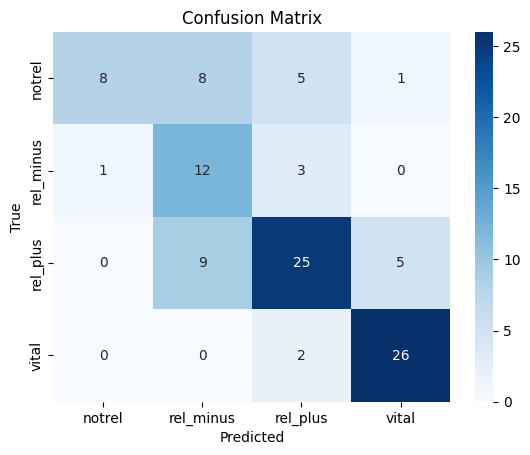

Распределение предсказанных классов:
predicted
rel_plus     35
vital        32
rel_minus    29
notrel        9
Name: count, dtype: int64


In [340]:
print("Метрики")
result = pd.read_pickle('prediction_cache_final.pkl')
test['key'] = test.apply(lambda row: hashlib.md5(f"{row['track_name']}_{row['author']}".encode()).hexdigest(), axis=1)
test['predicted'] = test['key'].map(result)

print(classification_report(y_test, test['predicted']))

# Confusion Matrix
cm = confusion_matrix(y_test, test['predicted'], labels=['notrel', 'rel_minus', 'rel_plus', 'vital'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['notrel', 'rel_minus', 'rel_plus', 'vital'], yticklabels=['notrel', 'rel_minus', 'rel_plus', 'vital'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Распределение предсказанных классов:")
print(test['predicted'].value_counts())

In [333]:
# Ошибки, где `rel_plus` классифицирован как `vital`
vital_rel_plus = test[(test['predicted'] == 'vital') & (test['golden_answer'] == 'rel_plus')]
vital_rel_plus.head()

,query,track_name,author,golden_answer,key,predicted
33,цой группа кино,Группа крови,Кино,rel_plus,174e449191d38795101605c0abcd102d,vital
47,песенка милана,Я МИЛАНА,Milana Star,rel_plus,9dbc26443b8d2dcc492778d5411dfba6,vital
56,сердючка,Дольче Габбана,Верка Сердючка,rel_plus,46b7006a3f67a406c2f9df8b11307aba,vital
78,включи сказки на ночь для детей,Сказки на ночь,Ансамбль Детские Песни,rel_plus,b88870131710048fc6987c26d5975b31,vital
104,цветы для элдж,Цветы для Элджернона,РАССВЕТОВ,rel_plus,b3269981c9c2788d584e1a455f962168,vital


In [334]:
# Ошибки, где `notrel` классифицирован как другой класс
test[(test['golden_answer'] == 'notrel') & (test['predicted'] != 'notrel')].head()

,query,track_name,author,golden_answer,key,predicted
12,снег падает на всех,Снег падает,Марк Тишман,notrel,9a66a1610ee36bc89c5fe057daf41d32,rel_plus
15,включи песни мистера кредо,Credo,Mr. DP,notrel,a4251b2a7e865afc2029288d17bac005,rel_minus
19,включи песню оп мусорок,Мусорок,Александр Новиков,notrel,dfe4442c009c9c15f7e803903b17f6dc,rel_plus
25,включи страшную песню тили тили бом закрой гла...,Tili Tili Bom,Dani Beats,notrel,f7596e1b3f0a63686d954b2db466410d,rel_plus
36,а моя любовь живет,Где живёт любовь моя?,Алина Атласова,notrel,07abd409f9d7e4d35f484084769758b4,rel_plus


In [335]:
# Ошибки, где `rel_minus` классифицирован как `rel_plus`
test[(test['golden_answer'] == 'rel_minus') & (test['predicted'] == 'rel_plus')].head()

,query,track_name,author,golden_answer,key,predicted
5,поставь клаву коку,РОЗОВАЯ ЛУНА,"Клава Кока,Джарахов,SQWOZ BAB",rel_minus,45104d4e1f8b9c4474b2ed15e2c1f0b5,rel_plus
13,орбак,Fi Orbak,Mayez El Bayaa,rel_minus,9e1e4dff3367e3dc8cb34ca9d15961dd,rel_plus
95,титаник музыка,На Титанике,"Лолита,INSTASAMKA",rel_minus,7a2b5ae63f63c860173d020d0a107d66,rel_plus


In [336]:
# Ошибки, где `rel_plus` классифицирован как `rel_minus`
test[(test['golden_answer'] == 'rel_plus') & (test['predicted'] == 'rel_minus')].head()

,query,track_name,author,golden_answer,key,predicted
16,дворовые песни восьмидесятых,Хиты 80-х,"Музыка В Машину,Танцевальная музыка,Дискотека ...",rel_plus,3dd98226a3e7ea27e1cd366a122f6f31,rel_minus
30,включи песню луна,ЛУНА,SHAMAN,rel_plus,f46754acf03c5f3a1616a90af0a558ac,rel_minus
31,полный концерт группы пикник,Пикник,Пикник,rel_plus,483e99e69d46fdffa4236d92b4a8846e,rel_minus
44,песня тонкая рябина,Тонкая рябина,Людмила Зыкина,rel_plus,914f23d6d1b5e0e2276a3ac75f7d8d10,rel_minus
49,маша и медведь песню,Барабашка,Маша и Медведь,rel_plus,2eff1fdde45612d4e75d06c32d2ed680,rel_minus
